In [16]:
# -------- Imports --------
import sys
import os
import numpy as np
import scipy.sparse as sp
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))
from _utility import *


# -- Qiskit imports --
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.quantum_info import Statevector
from qiskit.circuit.library import RYGate


### Vector rotation (n-D)

In [17]:
# -------- Parameters --------
# Define parameters
d = 3                               # Number of dimensions
n = 64                              # Number of gridpoints in each dimension (radial grid)
nn = 4                              # Initial state size

# Define number of qubits
q_d = int(np.ceil(np.log2(d)))      # Number of qubits for dimension
q_n = int(np.ceil(np.log2(n)))      # Number of qubits for grid in each dimension
q_nn = int(np.ceil(np.log2(nn)))    # Number of qubits for initial state

# 3D state
state_a = np.zeros(nn)              # X-direction (Longitudinal)
state_b = np.zeros(nn)              # Y-direction (Latitudinal)
state_c = np.linspace(1, 0.8, nn)   # Z-direction (Radial)
filler = np.zeros(nn)

# Reorder state
state_0 = np.hstack([state_c, filler, state_b, state_a]) 

# Normalize state
norm = np.linalg.norm(state_0)
state_0 = state_0 / norm


Number of qubits: 12
State size: 4096


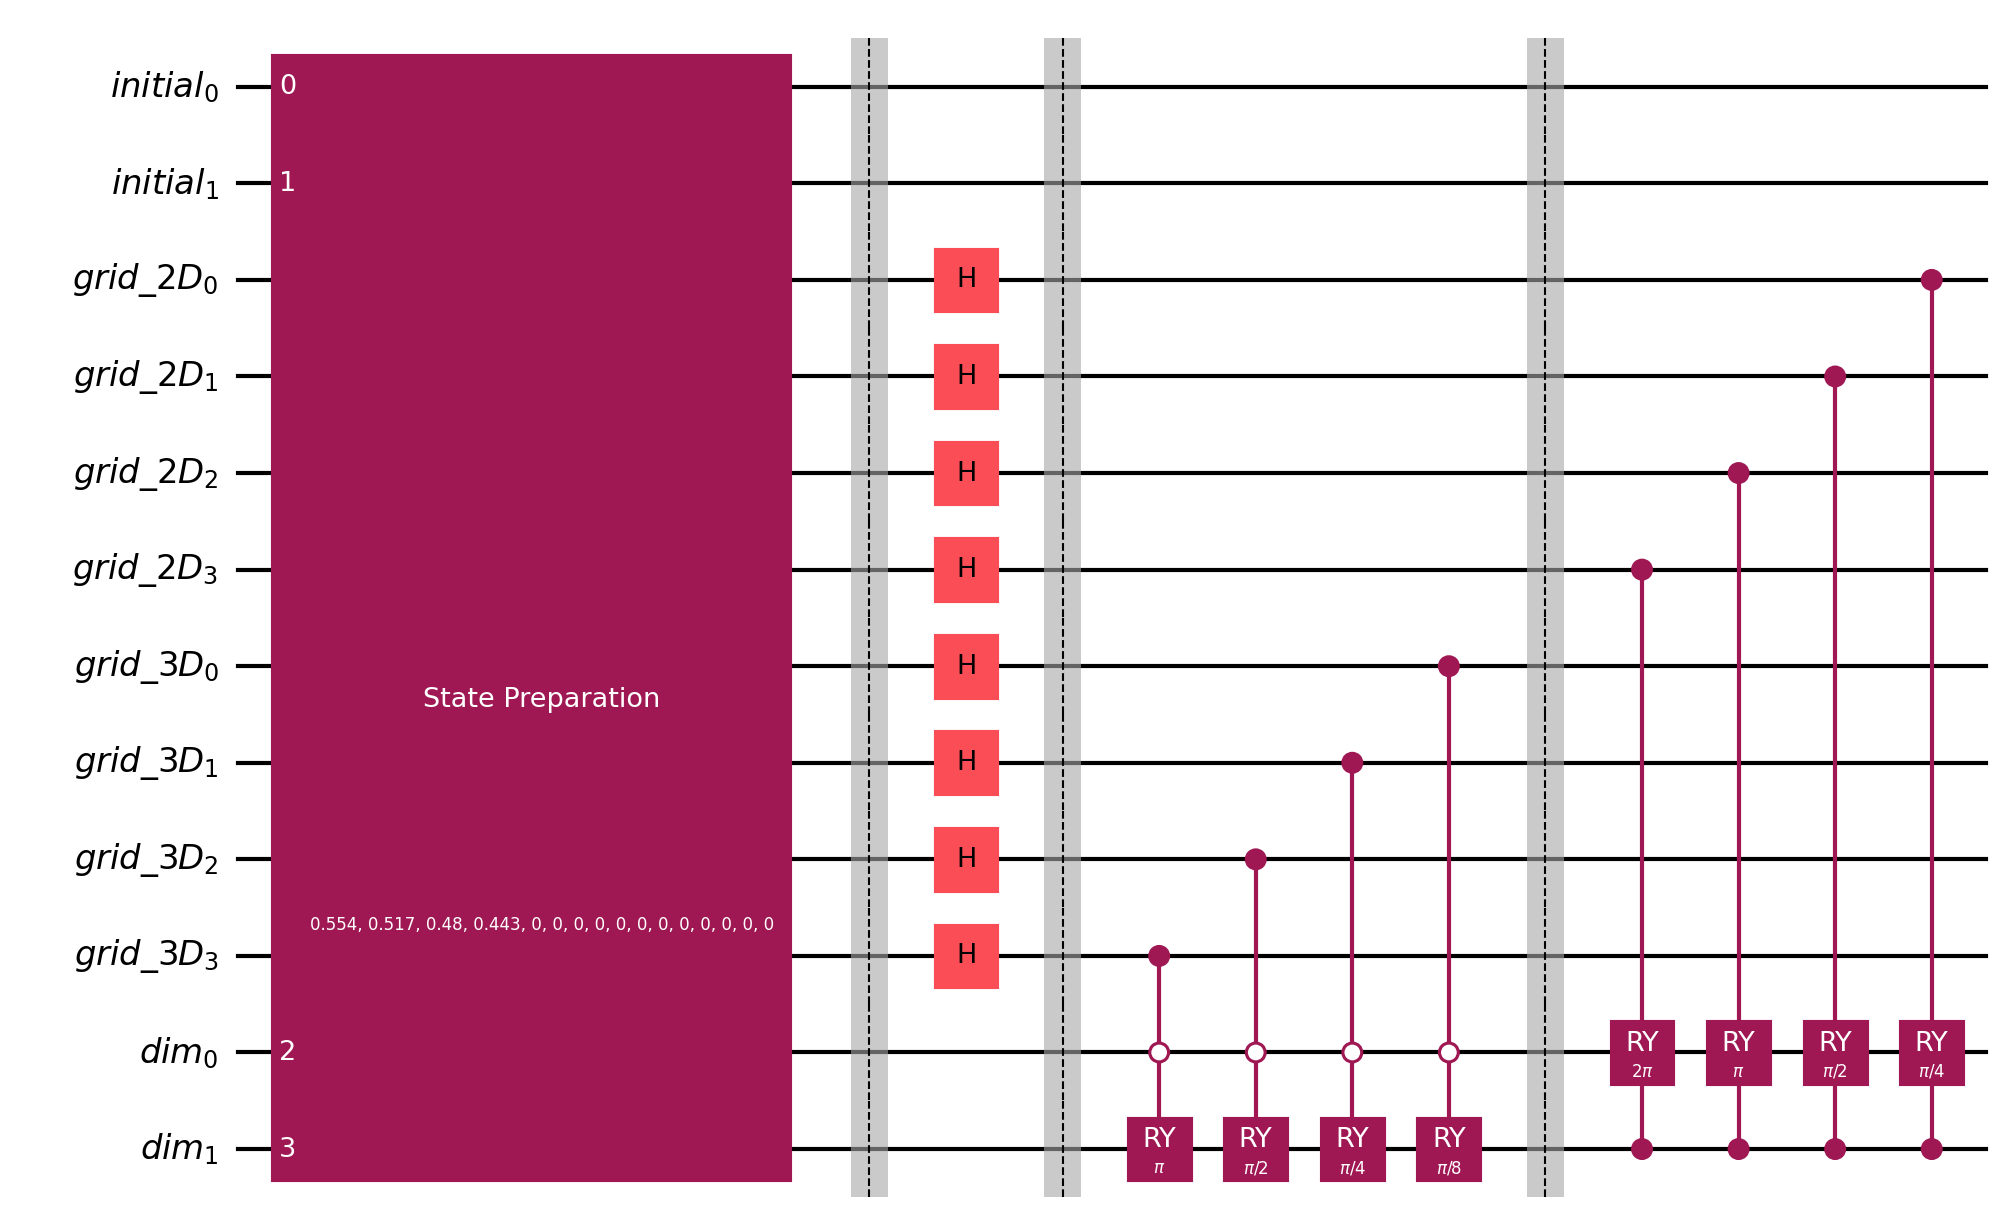

In [18]:
# -------- Quantum Circuit --------
# Define quantum registers
q_dim = QuantumRegister(q_d, 'dim')
q_grid = [QuantumRegister(q_n-q_nn, f'grid_{i+2}D') for i in range(d-1)]
q_initial = QuantumRegister(q_nn, 'initial')

# Create quantum circuit
qc = QuantumCircuit(q_initial, *q_grid, q_dim)              

# Initialize initial state
qc.prepare_state(state_0, [q_initial, q_dim])
qc.barrier()     

# Apply Hadamard gate (Duplicate initial state to full grid)
[qc.h(reg) for reg in q_grid]
qc.barrier()

# Rotatation around x-axis
for j, qubit in enumerate(q_grid[1][::-1]):
    theta = np.pi / 2**j
    ry = RYGate(theta, label='RY')
    mcry = ry.control(num_ctrl_qubits=2, ctrl_state='01')
    qc.append(mcry, [qubit, q_dim[0], q_dim[1]])
qc.barrier()

# Rotataion around z-axis
for j, qubit in enumerate(q_grid[0][::-1]):
    theta = 2*np.pi / 2**j
    ry = RYGate(theta, label='RY')
    mcry = ry.control(num_ctrl_qubits=2, ctrl_state='11')
    qc.append(mcry, [qubit, q_dim[1], q_dim[0]])

# Circuit properties
print('Number of qubits:', q_d + (d-1)*(q_n-q_nn) + q_nn) # Dimension + Grid + Initial state
print('State size:', 2**qc.num_qubits)

# Show circuit
qc.draw('mpl', scale=1.5)

# Save circuit drawing
# fig = qc.draw('mpl',  scale=1.5)
# plt.tight_layout()
# fig.savefig('circuit_3D.png')


In [19]:
# -------- Simulation --------
# Evolve state
state_final = Statevector.from_int(0, dims=2**qc.num_qubits).evolve(qc).data.real

# Reshape state
state_final = state_final.reshape([2**q_d] + (d-1)*[2**(q_n-q_nn)] + [2**q_nn]) * norm

# Reorder state (can also be implemented in the circuit (Ry-gates/X-gates/SWAP gates on dim register))
state_final = state_final[[2, 3, 0, 1]]
state_final[2] = -state_final[2]


# 3D Visualization

In [20]:
# -------- Plotting --------
fig = plot_field_3D(state_final)

# Show the interactive plot
fig.show()

# Save the plot
# title = '3D state_c'
# fig.write_image(f'{title}.png')
